In [10]:
#Importing basic packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import matplotlib.pyplot as plt
import seaborn as sns
#Importing packages for regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
#Supressing warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
#Custom Methods
#Let's define all custom methods here for code conciseness.

# Let's define a method for checking missing value count per column.
def missingValueCount(data_frame, threshold):
    missing_value = data_frame.isnull().sum()
    return missing_value.loc[missing_value > threshold]
# Let's define a method for checking missing value percentage per column.
def missingValuePercentage(data_frame, threshold):
    missing_value = round(house_price.isnull().sum()/len(house_price.index),2).sort_values(ascending=False)
    return missing_value.loc[missing_value > threshold]
#Defining method to calculate age from year
def yearToAge(data_frame,col):
    new_cal = col + '_Old'
    data_frame[new_cal] = data_frame[col].max()-house_price[col]
    
#Defining method for imputing missing values 
def imputingMissingValue(data_frame,col,value):
    data_frame[col].fillna(value, inplace = True)
#Defining method for outliers  treatment
def dropOutliers(data_frame, numerical_columns):
    list = []
    for col in numerical_columns:
        Q1 = data_frame[col].quantile(.25)
        Q3 = data_frame[col].quantile(.99)
        IQR = Q3-Q1
        data_frame =  data_frame[(data_frame[col] >= (Q1-(1.5*IQR))) & (data_frame[col] <= (Q3+(1.5*IQR)))] 
    return data_frame

In [14]:
#Custom methods for Plotting and Visualization
# Defining method for plotting graphs based on numerical/continuous variables
def numericColAnalysis(data_frame, index,independent_variable ,target_variable):
    plt.figure(figsize = (20, 26))
    plt.figure(index)
    sns.jointplot(x = independent_variable, y = target_variable, data = data_frame[[independent_variable,target_variable]])
# Defining method for plotting graphs based on categorical variables
def categoricalColAnalysis(data_frame, index,independent_variable ,target_variable):
    plt.figure(index)
    variables = data_frame[[independent_variable]].nunique()
    plt.figure(figsize = (variables,variables/1.77))
    my_order = data_frame[[independent_variable,target_variable]].groupby(by = [independent_variable])[target_variable].median().sort_values(ascending=True)
    sns.boxplot(x = independent_variable, y = target_variable, data= data_frame[[independent_variable,target_variable]], order = my_order.index)

In [17]:
#Step 1: Reading and Understanding the DataData loading and cleaning
#Data loading and cleaning
#Load data to pandas dataframe
house_price = pd.read_csv(r"C:\Users\Asus\Desktop\Project-Housing_splitted\train.csv")
#Firstly, let's have a look at the dimension of data
house_price.shape
(1460, 81)
#Let's have look on the metadata of the dataset
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    954 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          77 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

In [19]:
house_price.describe([0.25,0.50,0.75,0.99])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.000000,954.00000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1161.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1104.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,724.136130,56.767979,70.98847,10484.749144,6.104452,5.595890,1970.930651,1984.758562,102.310078,444.726027,46.647260,569.721747,1061.095034,1169.860445,348.826199,6.380137,1525.066781,0.425514,0.055651,1.562500,0.388699,2.884418,1.045377,6.542808,0.617295,1978.193841,1.776541,476.860445,96.206336,46.559932,23.015411,3.639555,15.051370,3.448630,47.315068,6.344178,2007.804795,181477.005993
std,416.159877,41.940650,24.82875,8957.442311,1.390153,1.124343,30.145255,20.785185,182.595606,462.664785,163.520016,449.375525,442.272249,391.161983,439.696370,50.892844,528.042957,0.521615,0.236699,0.551882,0.504929,0.817229,0.216292,1.598484,0.650575,24.890704,0.745554,214.466769,126.158988,66.381023,63.191089,29.088867,55.080816,44.896939,543.264432,2.686352,1.329738,79105.586863
min,1.000000,20.000000,21.00000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,360.500000,20.000000,60.00000,7621.500000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,0.000000,216.000000,799.000000,892.000000,0.000000,0.000000,1143.250000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,338.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130375.000000
50%,714.500000,50.000000,70.00000,9522.500000,6.000000,5.000000,1972.000000,1993.000000,0.000000,385.500000,0.000000,474.000000,1005.500000,1096.500000,0.000000,0.000000,1468.500000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163995.000000
75%,1079.500000,70.000000,80.00000,11515.500000,7.000000,6.000000,2000.000000,2004.000000,160.000000,714.500000,0.000000,816.000000,1291.500000,1392.000000,729.000000,0.000000,1795.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,171.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215000.000000
99%,1443.330000,190.000000,146.35000,36863.520000,10.000000,9.000000,2009.000000,2009.000000,804.000000,1583.890000,869.990000,1800.000000,2216.330000,2242.250000,1417.960000,363.630000,3121.240000,2.000000,1.000000,3.000000,1.000000,5.000000,2.000000,11.000000,2.000000,2009.000000,3.000000,1021.650000,502.970000,283.980000,265.320000,168.000000,265.330000,0.000000,915.500000,12.000000,2010.000000,443943.500000
max,1460.000000,190.000000,313.00000,164660.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,

In [20]:
missingValueCount(house_price, 0)

LotFrontage      214
Alley           1091
MasVnrType         7
MasVnrArea         7
BsmtQual          30
BsmtCond          30
BsmtExposure      31
BsmtFinType1      30
BsmtFinType2      31
FireplaceQu      551
GarageType        64
GarageYrBlt       64
GarageFinish      64
GarageQual        64
GarageCond        64
PoolQC          1161
Fence            931
MiscFeature     1124
dtype: int64

In [21]:
missingValuePercentage(house_price, 0)

PoolQC          0.99
MiscFeature     0.96
Alley           0.93
Fence           0.80
FireplaceQu     0.47
LotFrontage     0.18
GarageType      0.05
GarageCond      0.05
GarageYrBlt     0.05
GarageFinish    0.05
GarageQual      0.05
BsmtFinType1    0.03
BsmtExposure    0.03
BsmtCond        0.03
BsmtQual        0.03
BsmtFinType2    0.03
MasVnrArea      0.01
MasVnrType      0.01
dtype: float64

In [22]:
#Here I'm considering 10% as my threshold and dropping the column having more then the threshold

missing_data = missingValuePercentage(house_price, 0.10)
missing_data

PoolQC         0.99
MiscFeature    0.96
Alley          0.93
Fence          0.80
FireplaceQu    0.47
LotFrontage    0.18
dtype: float64

In [23]:
house_price = house_price.drop(list(missing_data.index),axis='columns')
#Checking the columns where the missing values less than or equal to 10%
missingValuePercentage(house_price, 0)

GarageCond      0.05
GarageType      0.05
GarageYrBlt     0.05
GarageFinish    0.05
GarageQual      0.05
BsmtFinType2    0.03
BsmtFinType1    0.03
BsmtExposure    0.03
BsmtCond        0.03
BsmtQual        0.03
MasVnrType      0.01
MasVnrArea      0.01
dtype: float64

In [24]:
#Converting the year column into age
yearToAge(house_price,'YearBuilt')
yearToAge(house_price,'YearRemodAdd')
yearToAge(house_price,'GarageYrBlt')
yearToAge(house_price,'YrSold')
#Let's have a look on data after converting into age
house_price[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','YearBuilt_Old','YearRemodAdd_Old',
             'GarageYrBlt_Old','YrSold_Old']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old
0,1976,1976,1977.0,2007,34,34,33.0,3
1,1970,1970,1970.0,2007,40,40,40.0,3
2,1996,1997,1997.0,2007,14,13,13.0,3
3,1977,1977,1977.0,2010,33,33,33.0,0
4,1977,2000,1977.0,2009,33,10,33.0,1


In [27]:
#Let's drop the actual Year columns
house_price = house_price.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'], axis = 'columns')
#Imputing missing value
#Some columns have values as NA, But they are usefull in our analysis, So here we try to impute those values with similar class/category.

imputingMissingValue(house_price,'MasVnrType', 'None')
imputingMissingValue(house_price,'MasVnrArea' ,house_price.MasVnrArea.mean())
imputingMissingValue(house_price,'BsmtQual', 'TA')
imputingMissingValue(house_price,'BsmtCond', 'TA')
imputingMissingValue(house_price,'BsmtExposure', 'No')
imputingMissingValue(house_price,'BsmtFinType1', 'Unf')
imputingMissingValue(house_price,'BsmtFinType2', 'Unf')
imputingMissingValue(house_price,'GarageType', 'Attchd')
imputingMissingValue(house_price,'GarageYrBlt_Old', -1)
imputingMissingValue(house_price,'GarageFinish', 'Unf')
imputingMissingValue(house_price,'GarageQual', 'TA')
imputingMissingValue(house_price,'GarageCond', 'TA')


In [29]:
#As per the analysis 'Street' & 'Utilities' is explaining the lowest varience hence dropping these columns.
house_price = house_price.drop(['Utilities','Street'], axis = 'columns')
#'Id' column is also of no use for our analysis hence dropping the column

house_price = house_price.drop('Id', axis = 'columns')

In [30]:
#Checking the columns where the missing values
missingValuePercentage(house_price, 0)

Series([], dtype: float64)

In [31]:
#Now, We have no null values in the dataset.

In [32]:
#Exploratory Data Analysis
#Lets plot some graph for the EDA purpose

#Get all numerical Columns
numerical_columns = house_price.select_dtypes(include = np.number).columns.tolist()
numerical_columns.remove('SalePrice')

In [33]:
#Get all categorical Columns
categorical_columns = house_price.select_dtypes(include = np.object).columns.tolist()
for col in categorical_columns:
    print(col,' : ',house_price[col].head().unique())

MSZoning  :  ['RL']
LotShape  :  ['IR1']
LandContour  :  ['Lvl']
LotConfig  :  ['Inside' 'CulDSac' 'FR2']
LandSlope  :  ['Gtl' 'Mod']
Neighborhood  :  ['NPkVill' 'NAmes' 'NoRidge' 'NWAmes']
Condition1  :  ['Norm']
Condition2  :  ['Norm']
BldgType  :  ['TwnhsE' '1Fam']
HouseStyle  :  ['1Story' '2Story']
RoofStyle  :  ['Gable' 'Flat' 'Hip']
RoofMatl  :  ['CompShg' 'Tar&Grv']
Exterior1st  :  ['Plywood' 'Wd Sdng' 'MetalSd' 'CemntBd']
Exterior2nd  :  ['Plywood' 'Wd Sdng' 'MetalSd' 'CmentBd']
MasVnrType  :  ['None' 'BrkFace' 'Stone']
ExterQual  :  ['TA' 'Gd']
ExterCond  :  ['TA' 'Gd']
Foundation  :  ['CBlock' 'PConc']
BsmtQual  :  ['Gd' 'TA']
BsmtCond  :  ['TA' 'Gd']
BsmtExposure  :  ['No' 'Gd' 'Av']
BsmtFinType1  :  ['ALQ' 'GLQ' 'BLQ']
BsmtFinType2  :  ['Unf' 'Rec']
Heating  :  ['GasA']
HeatingQC  :  ['TA' 'Ex' 'Gd']
CentralAir  :  ['Y']
Electrical  :  ['SBrkr']
KitchenQual  :  ['TA' 'Gd']
Functional  :  ['Typ']
GarageType  :  ['Attchd']
GarageFinish  :  ['RFn' 'Unf' 'Fin']
GarageQual  :  [

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1872 with 0 Axes>

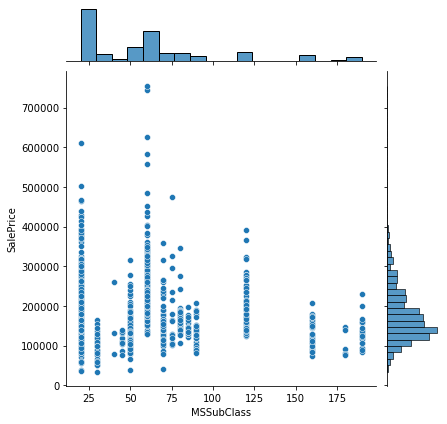

<Figure size 1440x1872 with 0 Axes>

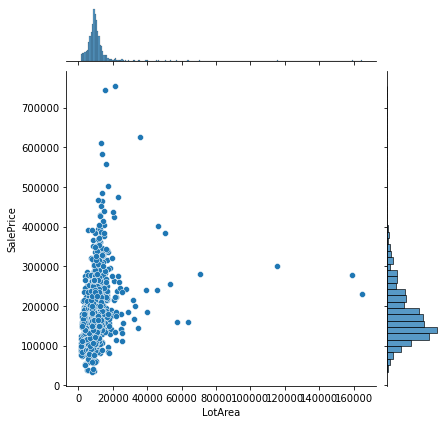

<Figure size 1440x1872 with 0 Axes>

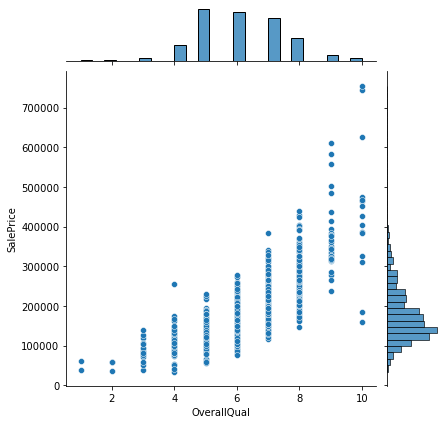

<Figure size 1440x1872 with 0 Axes>

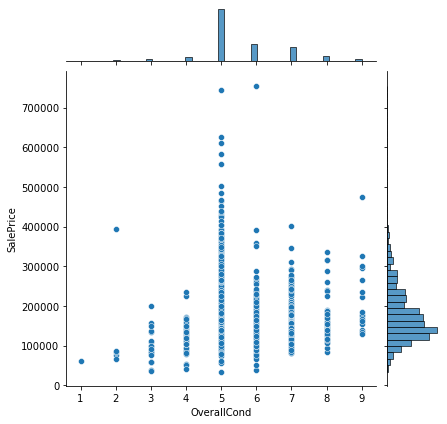

<Figure size 1440x1872 with 0 Axes>

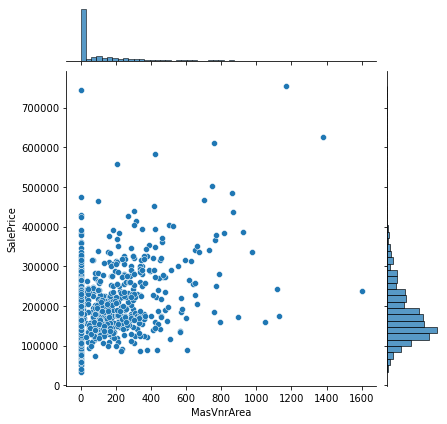

<Figure size 1440x1872 with 0 Axes>

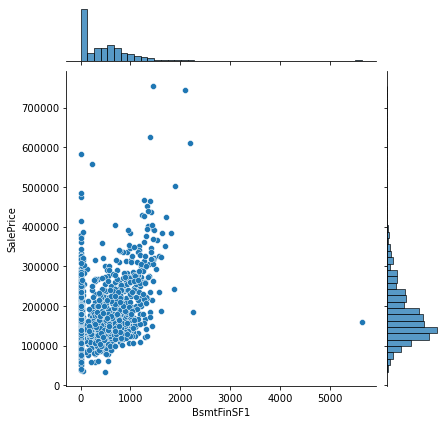

<Figure size 1440x1872 with 0 Axes>

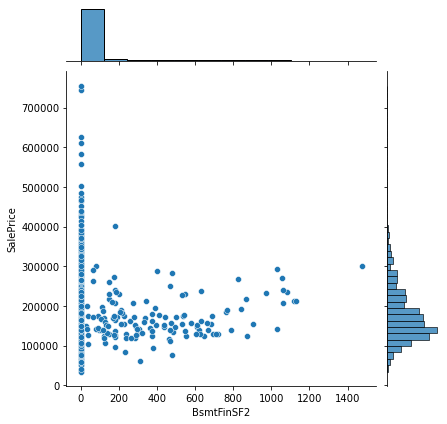

<Figure size 1440x1872 with 0 Axes>

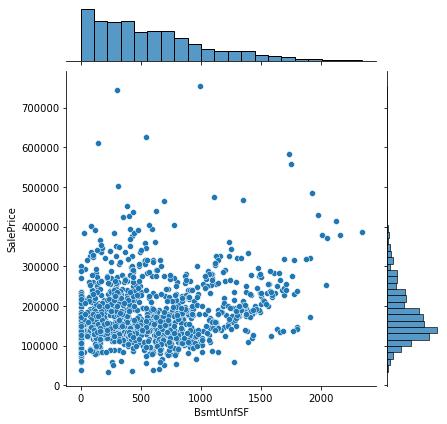

<Figure size 1440x1872 with 0 Axes>

<Figure size 1440x1872 with 0 Axes>

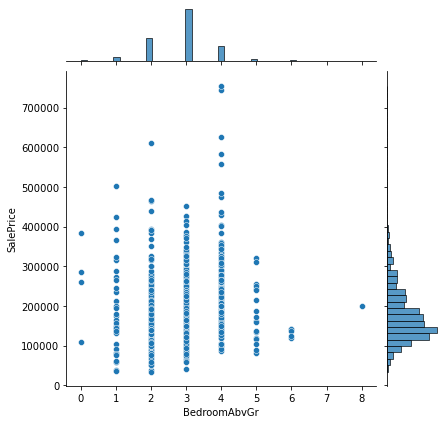

<Figure size 1440x1872 with 0 Axes>

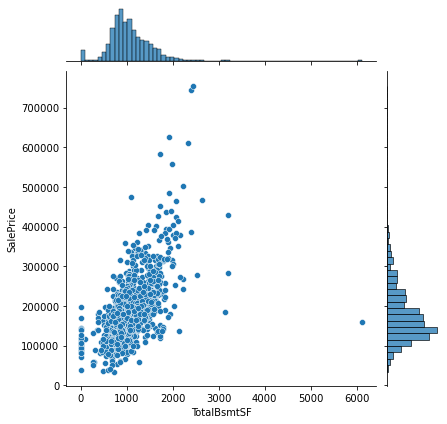

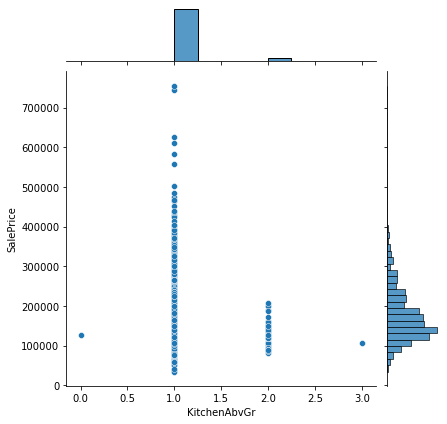

<Figure size 1440x1872 with 0 Axes>

<Figure size 1440x1872 with 0 Axes>

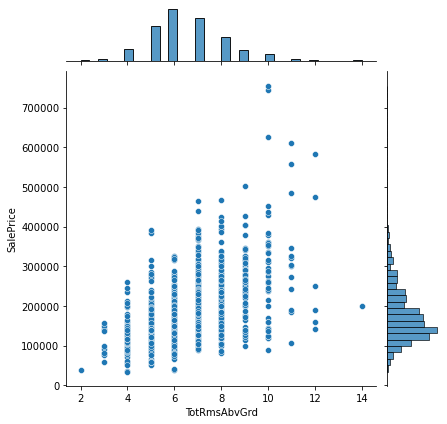

<Figure size 1440x1872 with 0 Axes>

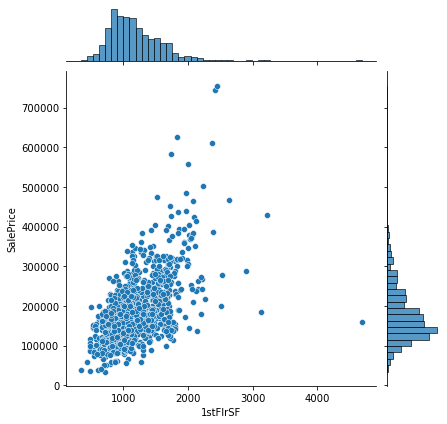

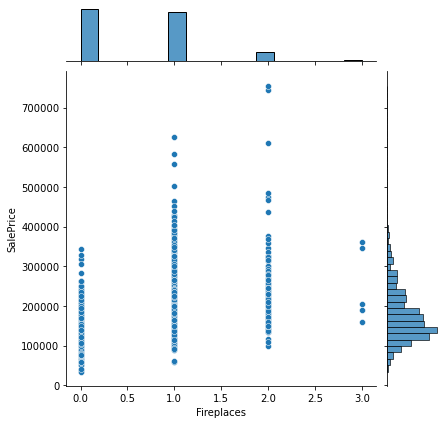

<Figure size 1440x1872 with 0 Axes>

<Figure size 1440x1872 with 0 Axes>

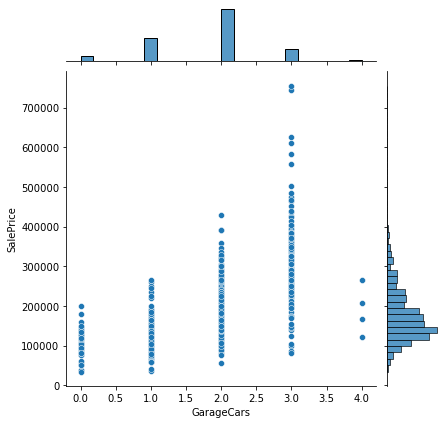

<Figure size 1440x1872 with 0 Axes>

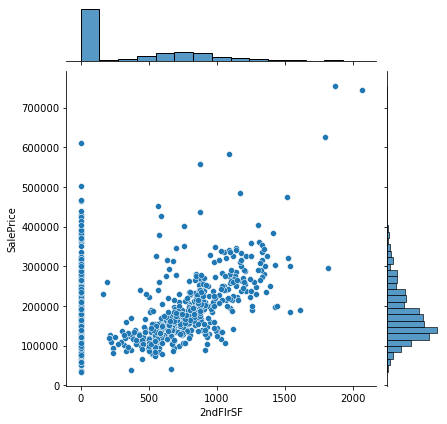

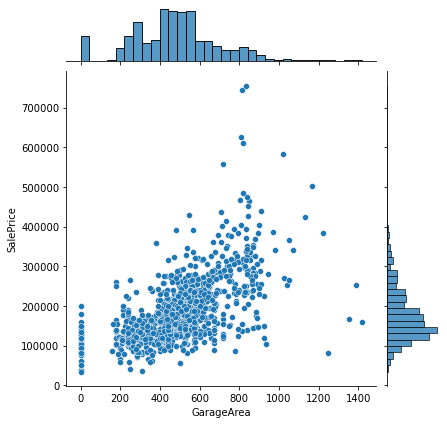

<Figure size 1440x1872 with 0 Axes>

<Figure size 1440x1872 with 0 Axes>

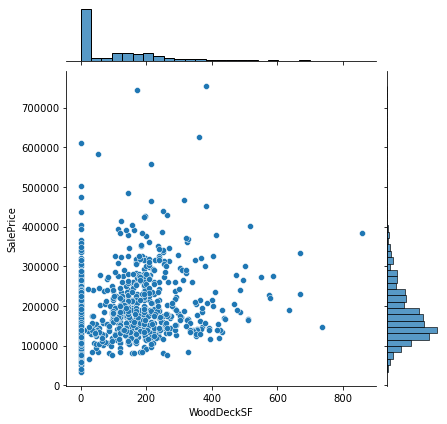

<Figure size 1440x1872 with 0 Axes>

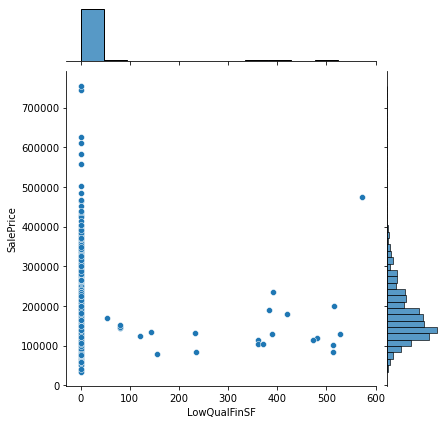

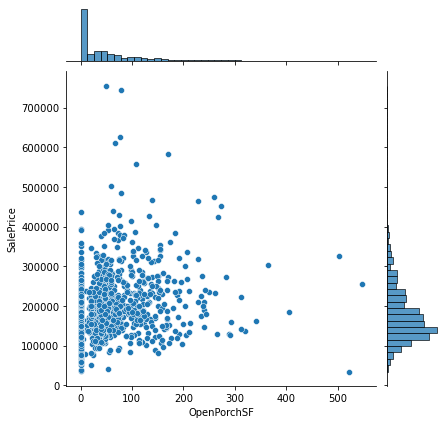

<Figure size 1440x1872 with 0 Axes>

<Figure size 1440x1872 with 0 Axes>

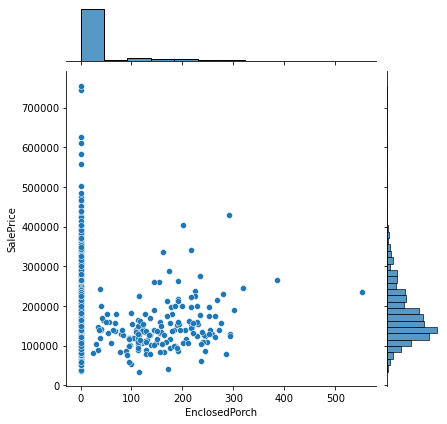

<Figure size 1440x1872 with 0 Axes>

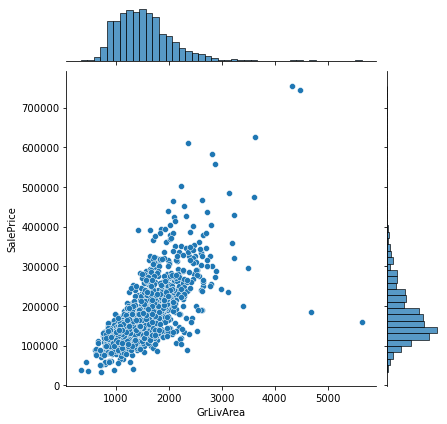

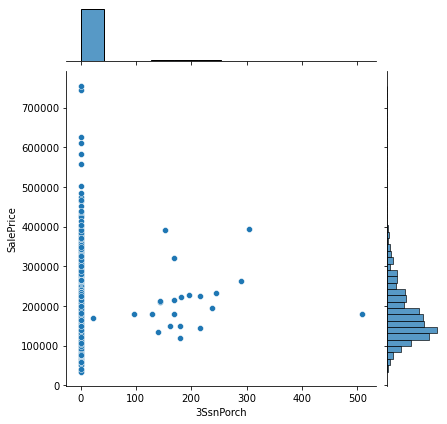

<Figure size 1440x1872 with 0 Axes>

<Figure size 1440x1872 with 0 Axes>

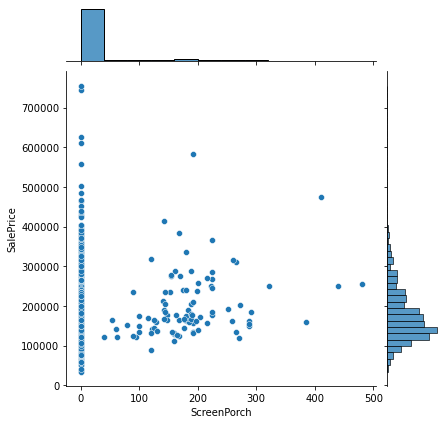

<Figure size 1440x1872 with 0 Axes>

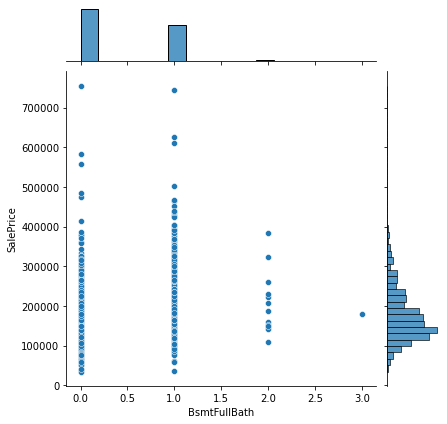

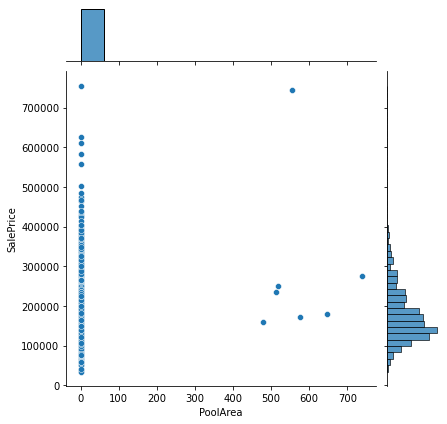

<Figure size 1440x1872 with 0 Axes>

<Figure size 1440x1872 with 0 Axes>

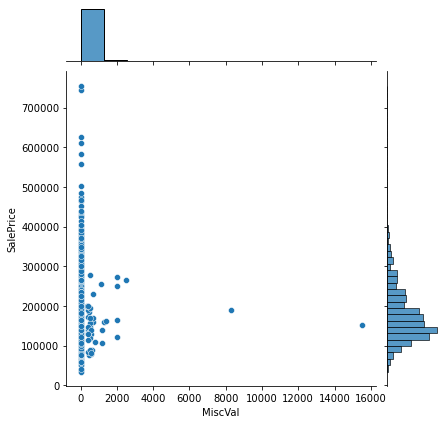

<Figure size 1440x1872 with 0 Axes>

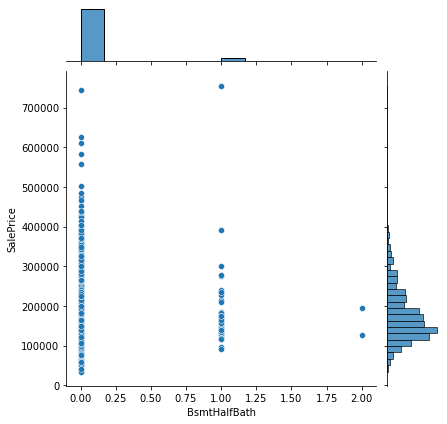

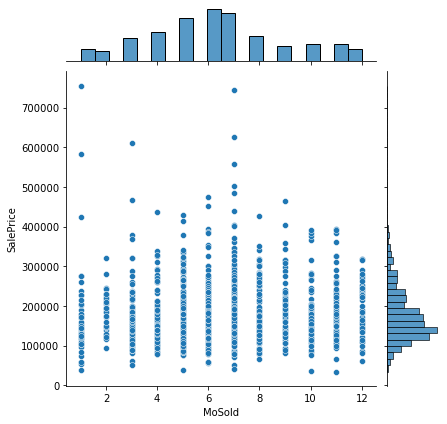

<Figure size 1440x1872 with 0 Axes>

<Figure size 1440x1872 with 0 Axes>

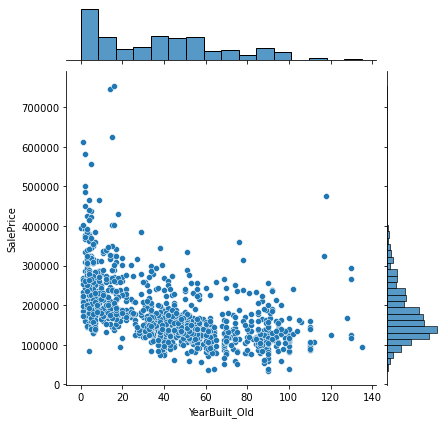

<Figure size 1440x1872 with 0 Axes>

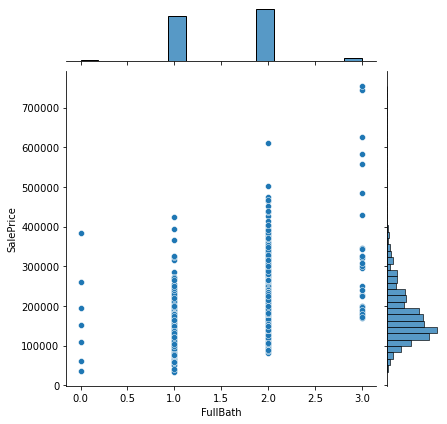

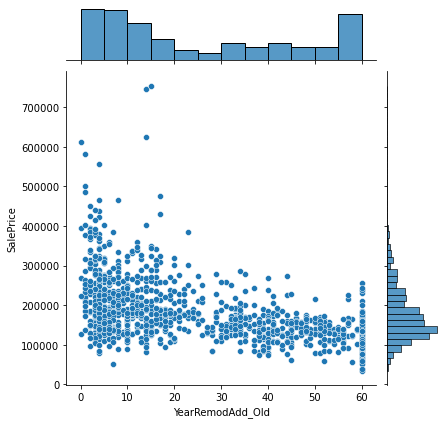

<Figure size 1440x1872 with 0 Axes>

<Figure size 1440x1872 with 0 Axes>

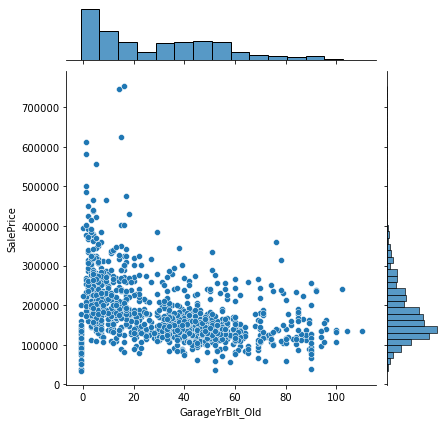

<Figure size 1440x1872 with 0 Axes>

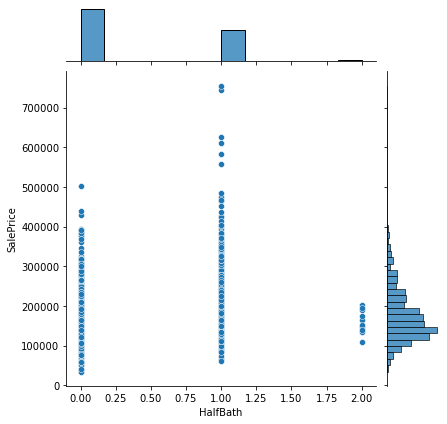

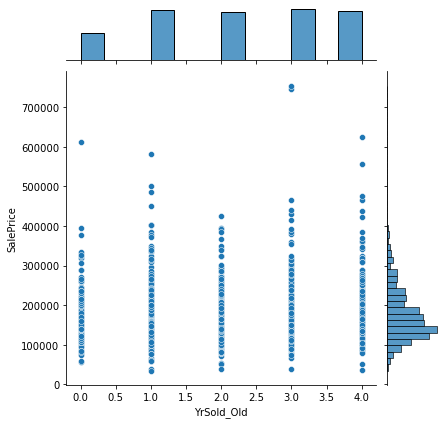

In [34]:
SaleCondition  :  ['Normal' 'Abnormal']
#Ploting the graph for all numerical variables
for index, col in enumerate(numerical_columns):
    numericColAnalysis(house_price, index, col, 'SalePrice')

<Figure size 432x288 with 0 Axes>

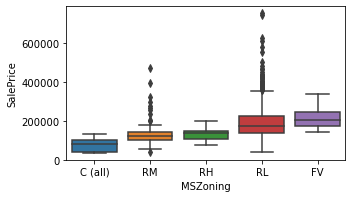

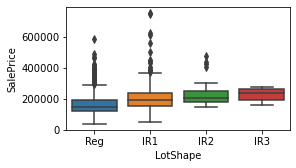

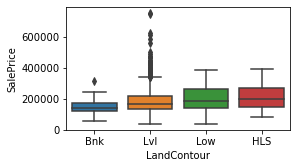

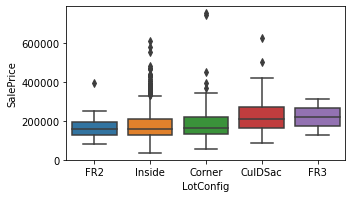

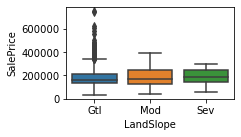

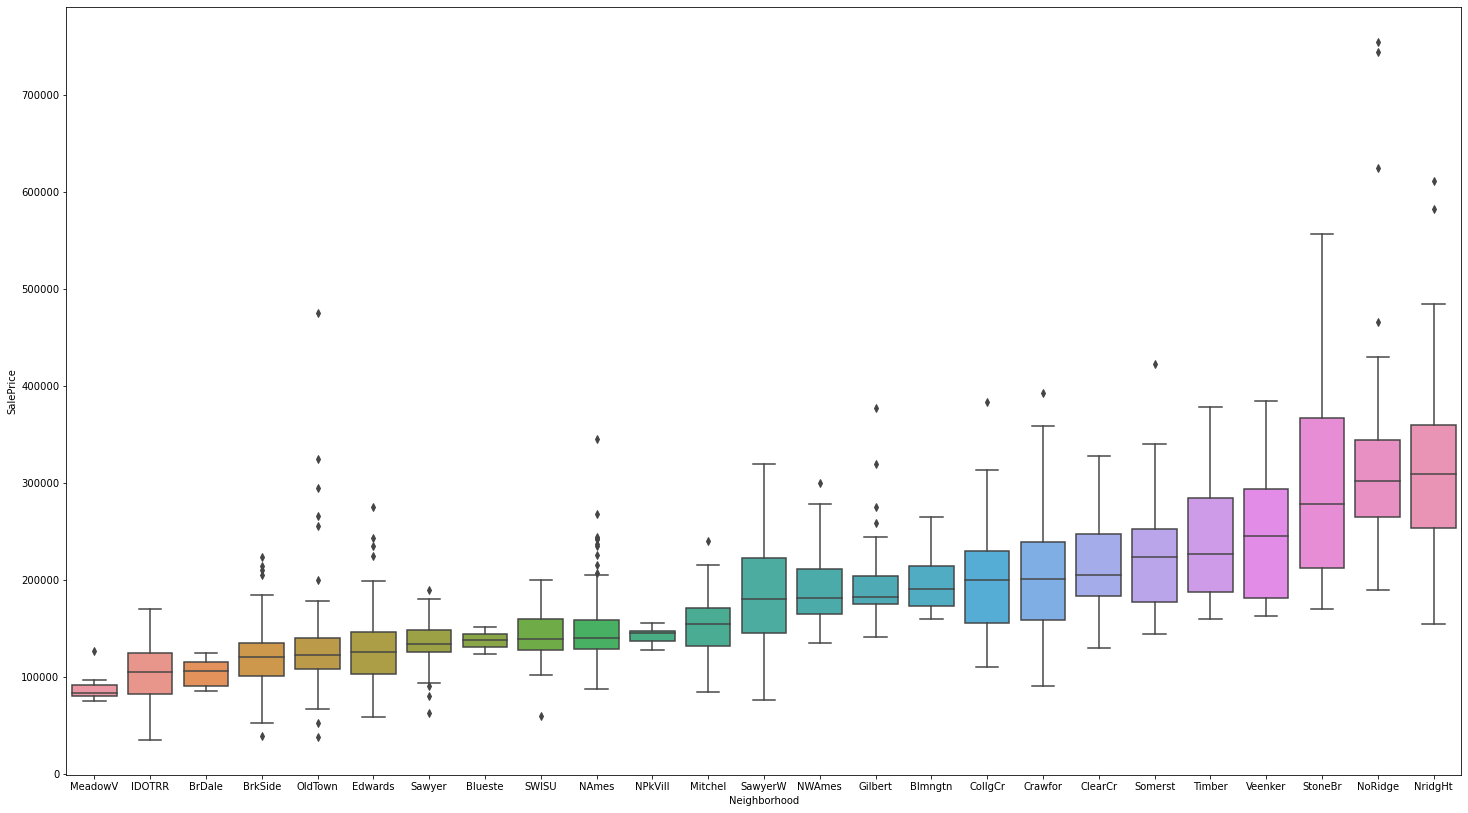

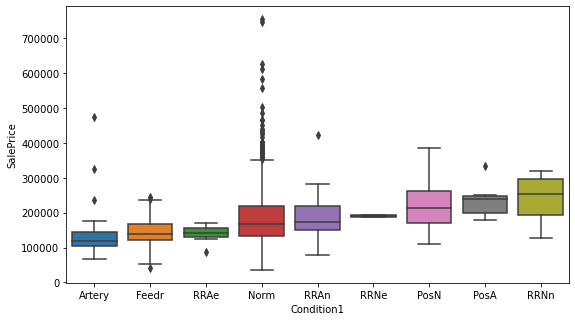

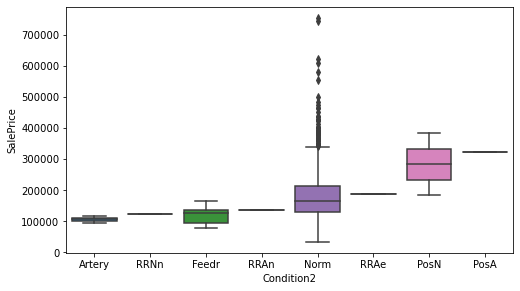

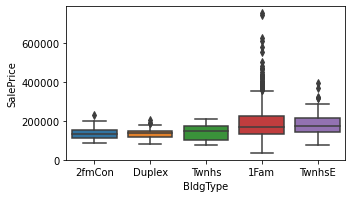

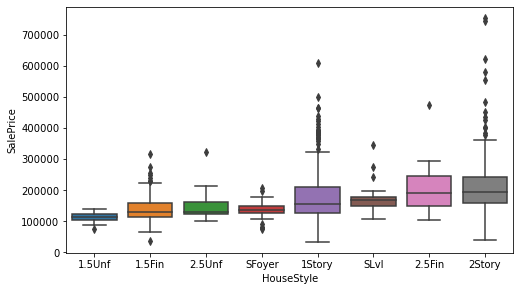

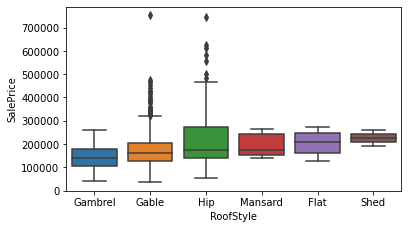

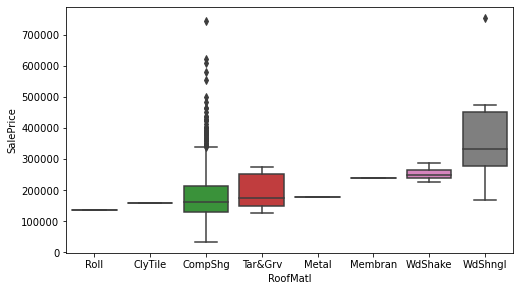

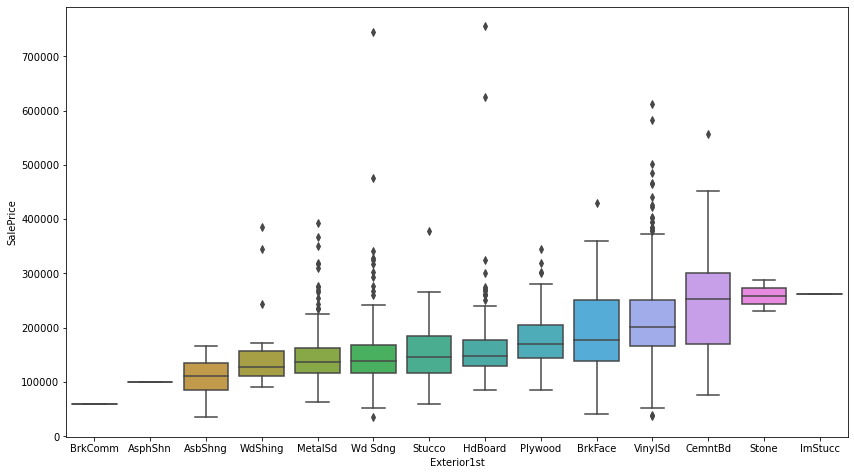

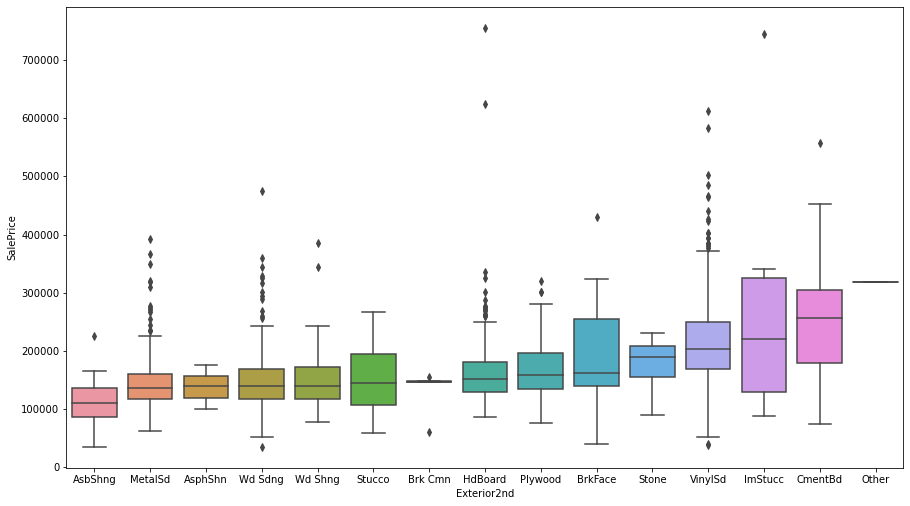

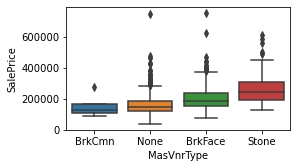

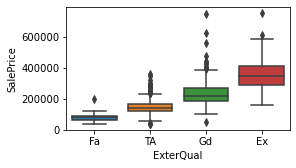

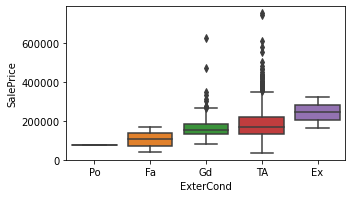

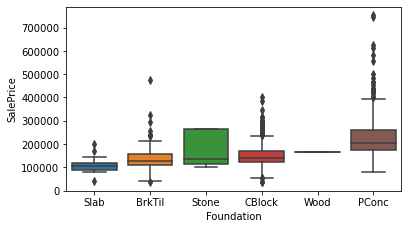

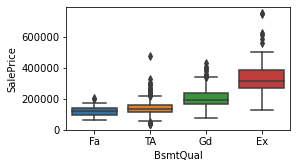

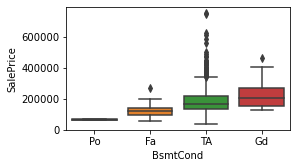

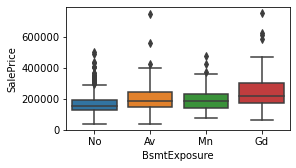

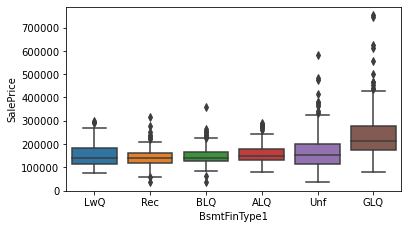

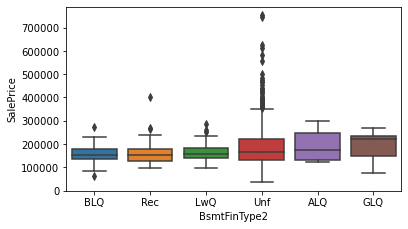

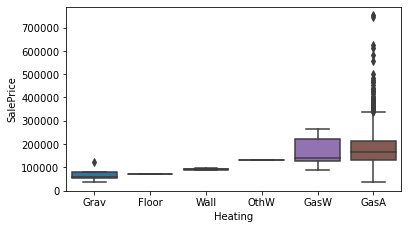

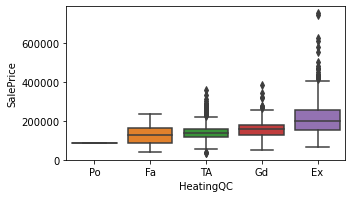

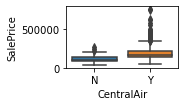

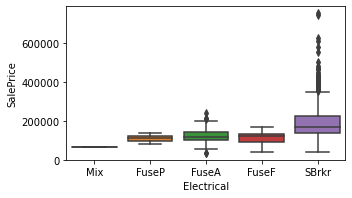

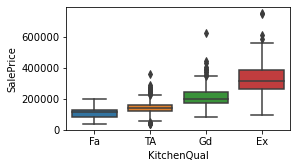

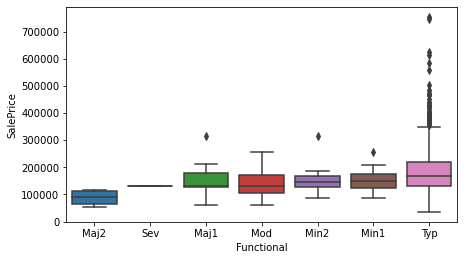

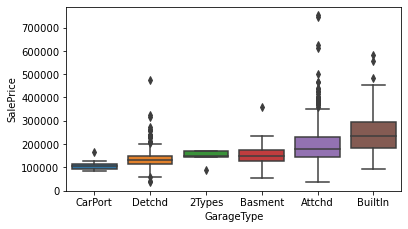

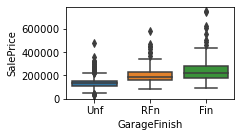

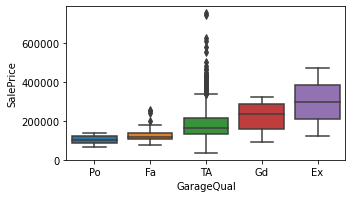

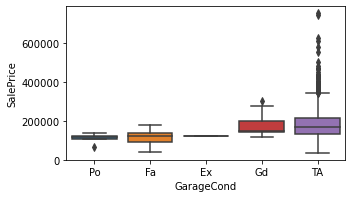

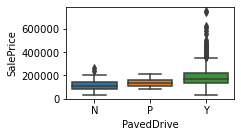

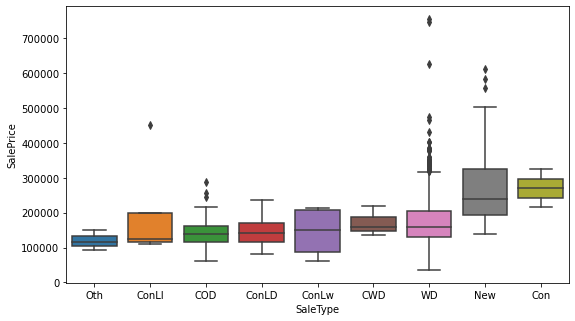

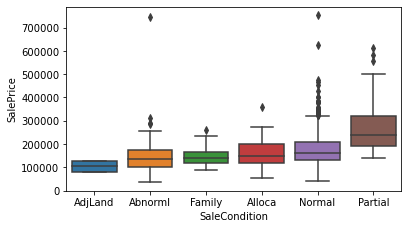

In [35]:
#Ploting the graph for all categorical variables
for index, col in enumerate(categorical_columns):
    categoricalColAnalysis(house_price, index, col, 'SalePrice')

In [37]:
#Let's do the outliers treatment where i am taking the lower and upper quantile as 0.25 & 0.99 respectively

numerical_columns = ['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF','GrLivArea','OpenPorchSF',
           'EnclosedPorch','3SsnPorch',
           'ScreenPorch' ,'PoolArea','MiscVal','SalePrice']
house_price = dropOutliers(house_price, numerical_columns)

In [38]:
#Let's have a look on first few columns
house_price[categorical_columns].head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,IR1,Lvl,Inside,Gtl,NPkVill,Norm,Norm,TwnhsE,1Story,Gable,CompShg,Plywood,Plywood,None,TA,TA,CBlock,Gd,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,IR1,Lvl,Inside,Mod,NAmes,Norm,Norm,1Fam,1Story,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,Gd,Gd,PConc,TA,Gd,Gd,ALQ,Rec,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
2,RL,IR1,Lvl,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,MetalSd,MetalSd,None,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
3,RL,IR1,Lvl,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Plywood,Plywood,BrkFace,TA,TA,CBlock,Gd,TA,No,BLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,COD,Normal
4,RL,IR1,Lvl,FR2,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,CemntBd,CmentBd,Stone,Gd,TA,CBlock,Gd,TA,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Attchd,Fin,TA,TA,Y,WD,Normal


In [39]:
#Let's check for the below columns, here we can clearly see that these are having some kind of order and hence we can say these are ordinal in nature.

ordinal_columns = ['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']
house_price[ordinal_columns].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,Gtl,TA,Gd,TA,No,ALQ,Unf,TA,Y,TA,RFn,TA,TA,TA,IR1
1,Mod,Gd,TA,Gd,Gd,ALQ,Rec,Ex,Y,Gd,Unf,TA,TA,Gd,IR1
2,Gtl,Gd,Gd,TA,Av,GLQ,Unf,Ex,Y,TA,Unf,TA,TA,TA,IR1
3,Gtl,TA,Gd,TA,No,BLQ,Unf,Ex,Y,TA,RFn,TA,TA,TA,IR1
4,Gtl,Gd,Gd,TA,No,ALQ,Unf,Gd,Y,Gd,Fin,TA,TA,TA,IR1


In [40]:
# Let's convert categorical variable to numeric. 
#we convert categorical variables into factors i.e number because to make things easy.
house_price[ordinal_columns[0]] = house_price[ordinal_columns[0]].map({'Gtl':0,'Mod':1,'Sev':2})
house_price[ordinal_columns[1]] = house_price[ordinal_columns[1]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price[ordinal_columns[2]] = house_price[ordinal_columns[2]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price[ordinal_columns[3]] = house_price[ordinal_columns[3]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price[ordinal_columns[4]] = house_price[ordinal_columns[4]].map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
house_price[ordinal_columns[5]] = house_price[ordinal_columns[5]].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price[ordinal_columns[6]] = house_price[ordinal_columns[6]].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price[ordinal_columns[7]] = house_price[ordinal_columns[7]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price[ordinal_columns[8]] = house_price[ordinal_columns[8]].map({'N':0,'Y':1})
house_price[ordinal_columns[9]] = house_price[ordinal_columns[9]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price[ordinal_columns[10]] = house_price[ordinal_columns[10]].map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
house_price[ordinal_columns[11]] = house_price[ordinal_columns[11]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price[ordinal_columns[12]] = house_price[ordinal_columns[12]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price[ordinal_columns[13]] = house_price[ordinal_columns[13]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price[ordinal_columns[14]] = house_price[ordinal_columns[14]].map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})
#Lets have a look into the converted columns

house_price[ordinal_columns].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,0,2,4,3,1,5,1,2,1,2,2,3,3,2,0
1,1,3,3,4,4,5,3,4,1,3,1,3,3,3,0
2,0,3,4,3,3,6,1,4,1,2,1,3,3,2,0
3,0,2,4,3,1,4,1,4,1,2,2,3,3,2,0
4,0,3,4,3,1,5,1,3,1,3,3,3,3,2,0


In [41]:
#Creating and joining dummy variables with the actual dataset

dummy_col = pd.get_dummies(house_price[['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition']],
                           drop_first=True)

house_price = pd.concat([house_price,dummy_col],axis='columns')

house_price = house_price.drop(['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition'],axis='columns')

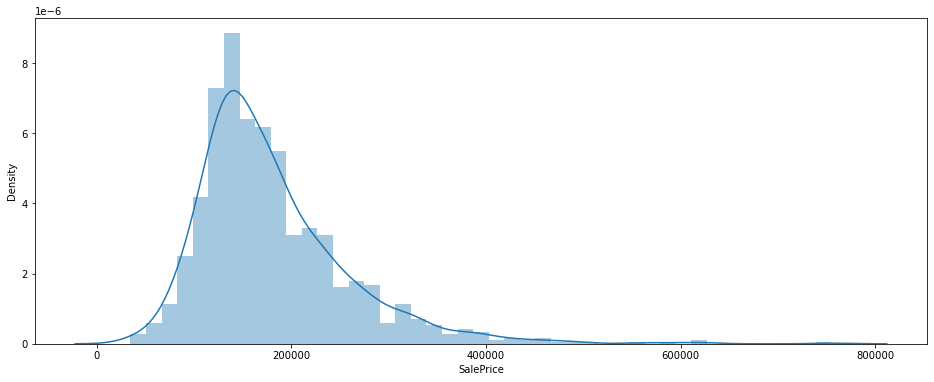

In [43]:
#Let's check the distribution of our target variable before scaling and Splitting

# Plotting the graph
plt.figure(figsize=(16,6))
sns.distplot(house_price.SalePrice)
plt.show()

In [44]:
#Splitting the dataset into train and test for modeling

df_train,df_test = train_test_split(house_price,train_size=0.7,test_size=0.3,random_state=50)
#Scaling the train dataset

#Rescaling the Features There are two major methods to scale the variables, i.e. standardisation and MinMax scaling. Standardisation basically brings all of the data into a standard normal distribution with mean zero and standard deviation one. MinMax scaling, on the other hand, brings all of the data in the range of 0 and 1. The formulae in the background used for each of these methods are as given below:

#Standardisation - (mean-0, sigma- 1) MinMax Scaling - (Normalisation): compress data between 0 and 1 This time, we will use minMax scaling

numerical_columns = house_price.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
df_test[numerical_columns] = scaler.transform(df_test[numerical_columns])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

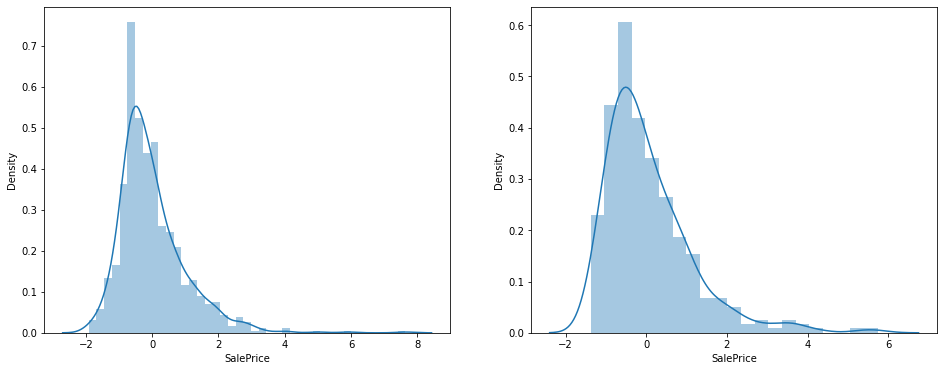

In [45]:
#Lets check the distribution again after scaling of test and train

plt.figure(figsize=(16,6))
plt.subplot(121)
sns.distplot(df_train.SalePrice)
plt.subplot(122)
sns.distplot(df_test.SalePrice)

In [47]:
#Training the Model
#Now that we have prepared the data and are done with the test-train split. 
#Let's divide into X and y sets for the model building.

y_train = df_train.pop('SalePrice')
X_train = df_train
y_test = df_test.pop('SalePrice')
X_test = df_test

In [64]:
# Running RFE with the output number of the variable equal to 70
lm  = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression())

In [65]:
rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

In [67]:
#Check RFE selected variables
rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)
rfe_sel_columns

['MSSubClass',
 'LotArea',
 'LotShape',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'ExterQual',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenQual',
 'Fireplaces',
 'GarageFinish',
 'GarageCars',
 'OpenPorchSF',
 'PoolArea',
 'MoSold',
 'GarageYrBlt_Old',
 'YrSold_Old',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'LandContour_HLS',
 'LotConfig_CulDSac',
 'Neighborhood_BrDale',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_StoneBr',
 'Condition1_Norm',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition2_PosA',
 'BldgType_2fmCon',
 'BldgType_Twnhs',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2

In [68]:
#Lets filter the train and test set for the RFE selected columns

X_train = X_train[rfe_sel_columns]
X_test = X_test[rfe_sel_columns]
#Lets try first with the Lasso regression model
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.9251742463799674
0.7993000471114138


In [69]:
model_parameter = list(lm.coef_)
model_parameter.insert(0,lm.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = df_train.columns
col.insert(0,'Constant')
list(zip(col,model_parameter))

[('MSSubClass', 0.0),
 ('LotArea', -0.113),
 ('LotShape', 0.075),
 ('LandSlope', 0.023),
 ('OverallQual', 0.149),
 ('OverallCond', 0.078),
 ('MasVnrArea', 0.081),
 ('ExterQual', 0.032),
 ('ExterCond', 0.056),
 ('BsmtQual', 0.05),
 ('BsmtCond', 0.025),
 ('BsmtExposure', 0.089),
 ('BsmtFinType1', 0.017),
 ('BsmtFinSF1', -0.0),
 ('BsmtFinType2', 0.109),
 ('BsmtFinSF2', 0.0),
 ('BsmtUnfSF', 0.085),
 ('TotalBsmtSF', 0.016),
 ('HeatingQC', 0.39),
 ('CentralAir', 0.02),
 ('1stFlrSF', 0.023),
 ('2ndFlrSF', -0.058),
 ('LowQualFinSF', 0.064),
 ('GrLivArea', 0.026),
 ('BsmtFullBath', 0.026),
 ('BsmtHalfBath', 0.035),
 ('FullBath', 0.02),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', -0.018),
 ('KitchenAbvGr', -0.038),
 ('KitchenQual', 0.026),
 ('TotRmsAbvGrd', 0.053),
 ('Fireplaces', 0.01),
 ('GarageFinish', 0.079),
 ('GarageCars', 0.061),
 ('GarageArea', 0.022),
 ('GarageQual', 0.048),
 ('GarageCond', 0.025),
 ('WoodDeckSF', 0.033),
 ('OpenPorchSF', -0.016),
 ('EnclosedPorch', -0.03),
 ('3SsnPorch', -0.

In [70]:
# Using KFold for model valodation
folds = KFold(n_splits=10,shuffle=True,random_state=50)

hyper_param = {'alpha':[0.001, 0.01, 0.1,1.0, 5.0, 10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True,
                        n_jobs = -1
                       )

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=50, shuffle=True),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [71]:
# Let have a look on the summery of test and train score based on alpha
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.083039,0.009860,0.009252,0.003227,0.001,{'alpha': 0.001},0.894235,0.940576,0.855822,0.892276,0.892365,0.882607,0.842819,0.864106,0.880321,0.902441,0.884757,0.025845,1,0.926919,0.921664,0.929003,0.926950,0.925120,0.926590,0.929666,0.927953,0.927349,0.924600,0.926581,0.002199
1,0.018308,0.003652,0.008521,0.003101,0.010,{'alpha': 0.01},0.897905,0.923198,0.847908,0.891837,0.884068,0.870870,0.853178,0.876059,0.867461,0.885234,0.879772,0.020918,2,0.913768,0.908675,0.914714,0.912763,0.911951,0.914389,0.915498,0.914860,0.914057,0.910567,0.913124,0.002047
2,0.014221,0.002641,0.007002,0.001658,0.100,{'alpha': 0.1},0.858916,0.852664,0.714583,0.848622,0.842623,0.800416,0.807766,0.874431,0.788712,0.780887,0.816962,0.045758,3,0.830374,0.823759,0.838246,0.833485,0.832008,0.827818,0.826701,0.826270,0.835698,0.826164,0.830052,0.004472
3,0.012956,0.003792,0.007034,0.001117,1.000,{'alpha': 1.0},-0.000463,-0.004961,-0.066886,-0.003128,-0.001571,-0.023062,-0.005957,-0.018202,-0.000265,-0.016329,-0.014082,0.019217,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.010036,0.000710,0.006210,0.001752,5.000,{'alpha': 5.0},-0.000463,-0.004961,-0.066886,-0.003128,-0.001571,-0.023062,-0.005957,-0.018202,-0.000265,-0.016329,-0.014082,0.019217,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


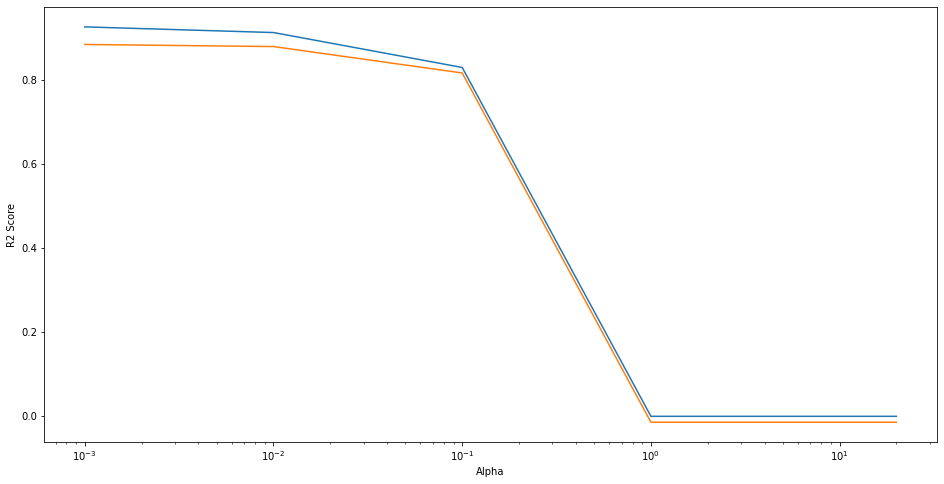

In [72]:
# Plot showing comparision of test and train score
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [73]:
# Checking the best parameter(Alpha value)
model_cv.best_params_
{'alpha': 0.001}
# After performing grid search we found the same alpha that ue use before
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.9251742463799674
0.7993000471114138


In [74]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = df_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Featuere','Coef']

In [75]:
# Significant variables which predict price of house when used lasso
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Featuere,Coef
18,HeatingQC,0.389621
93,Condition2_Feedr,0.267835
4,OverallQual,0.148536
72,Neighborhood_NAmes,0.140611
14,BsmtFinType2,0.109361
11,BsmtExposure,0.088638
16,BsmtUnfSF,0.084766
6,MasVnrArea,0.081376
33,GarageFinish,0.079032
5,OverallCond,0.078332


In [76]:
#Now lets use the ridge regression
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
print(r2_score(y_train,y_train_pred))
y_test_pred = ridge.predict(X_test)
print(r2_score(y_test,y_test_pred))

0.9266172983088362
0.7893948703331914


In [77]:
folds  = KFold(n_splits=10,shuffle=True,random_state=50)

hyper_param = {'alpha':[0.001,0.01,0.1,0.2,0.5,0.9,1.0, 5.0, 10.0,20.0]}

model = Ridge()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        n_jobs = -1,
                        return_train_score=True)
                        

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=50, shuffle=True),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1.0, 5.0,
                                   10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [78]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.132664,0.062893,0.007310,0.000738,0.001,{'alpha': 0.001},0.888280,0.944330,0.856422,0.885756,0.898040,0.888240,0.837537,0.867363,0.882114,0.902193,0.885028,0.027196,10,0.928331,0.923136,0.930192,0.928472,0.926552,0.927659,0.931151,0.929093,0.928871,0.926313,0.927977,0.002139
1,0.010137,0.001129,0.006406,0.001764,0.010,{'alpha': 0.01},0.888288,0.944325,0.856425,0.885773,0.898041,0.888233,0.837551,0.867362,0.882117,0.902201,0.885032,0.027193,9,0.928331,0.923136,0.930192,0.928472,0.926552,0.927659,0.931151,0.929093,0.928871,0.926313,0.927977,0.002139
2,0.011060,0.001689,0.006119,0.001354,0.100,{'alpha': 0.1},0.888367,0.944278,0.856453,0.885940,0.898044,0.888161,0.837687,0.867358,0.882146,0.902281,0.885072,0.027162,8,0.928330,0.923135,0.930191,0.928471,0.926551,0.927659,0.931150,0.929092,0.928870,0.926312,0.927976,0.002139
3,0.009821,0.001300,0.006777,0.001322,0.200,{'alpha': 0.2},0.888453,0.944227,0.856484,0.886120,0.898048,0.888083,0.837834,0.867353,0.882176,0.902365,0.885114,0.027128,7,0.928327,0.923132,0.930189,0.928468,0.926548,0.927658,0.931147,0.929089,0.928866,0.926309,0.927973,0.002139
4,0.010566,0.000660,0.005879,0.000536,0.500,{'alpha': 0.5},0.888699,0.944078,0.856579,0.886628,0.898054,0.887852,0.838255,0.867337,0.882256,0.902588,0.885232,0.027030,6,0.928308,0.923114,0.930171,0.928447,0.926528,0.927653,0.931126,0.929072,0.928847,0.926287,0.927955,0.002138


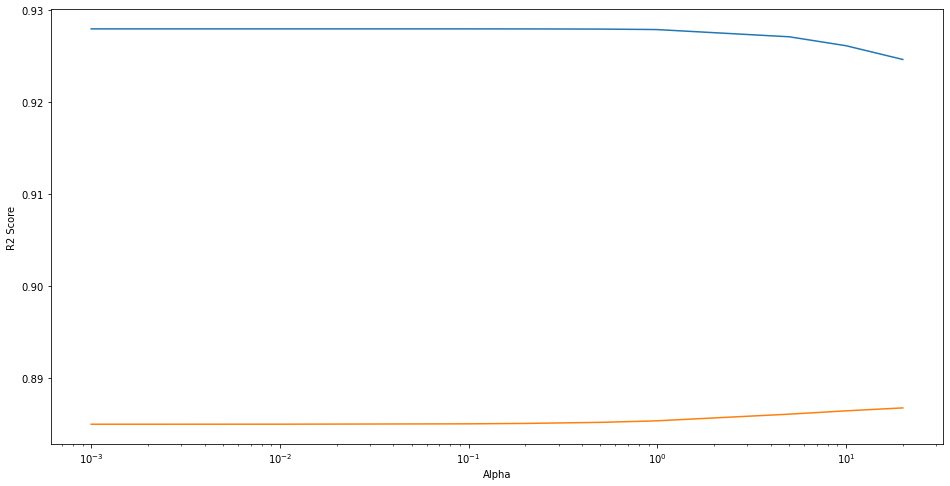

In [79]:
# Plot showing comparision of test and train score
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

In [ ]:
#On the basis of above graph lets create the model

In [80]:


# Checking the best parameter(Alpha value)
model_cv.best_params_
{'alpha': 20.0}
# After performing grid search we found the optimal alpha to be 20, so let's predict the test and train scores.
ridge = Ridge(alpha = 20.0)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.9234912058614559
0.8037691284855613


In [81]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = df_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feaure','Coef']

In [82]:
# Significant variables which predict price of house when used ridge
ridge_coef.sort_values(by = 'Coef',ascending = False).head(10)

,Feaure,Coef
18,HeatingQC,0.231597
16,BsmtUnfSF,0.174772
4,OverallQual,0.145718
93,Condition2_Feedr,0.117108
15,BsmtFinSF2,0.104956
14,BsmtFinType2,0.103907
72,Neighborhood_NAmes,0.095693
11,BsmtExposure,0.089247
6,MasVnrArea,0.082823
63,Neighborhood_BrkSide,0.077492


In [83]:
#Final Model
# We have used lasso for building the modle as we got the optimal value of alpha.
lasso = Lasso(alpha = 0.001)
lasso.fit(X_train,y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true = y_train,y_pred = y_train_pred))
print(r2_score(y_true = y_test,y_pred = y_test_pred))

0.9251742463799674
0.7993000471114138


Conclusion
These variables are significant in predicting the price of a house :

BsmtFinSF2 : Type 2 finished square feet.
LotShape : General shape of property.
ExterCond : Evaluates the present condition of the material on the exterior.
GarageCars : Size of garage in car capacity.
Neighborhood_Gilbert : Physical locations within Ames city limits(Gilbert).
BsmtFinSF1 : Type 1 finished square feet.
OverallQual : Rates the overall material and finish of the house.
BsmtExposure : Refers to walkout or garden level walls.
CentralAir : Central air conditioning.
OverallCond : Rates the overall condition of the house.
The optimal value of lambda for ridge and lasso regression are :

Best alpha value for Lasso : 0.001

Best alpha value for Ridge : 20.0